# 🎧 Kaggle Podcast Listening Time Prediction 📊
#### Predicting Podcast Popularity from Episode Metadata 🎯  
*A Kaggle Competition Submission Notebook*  
> 📅 **Competition**: [Kaggle - Playground Series S5E4](https://www.kaggle.com/competitions/playground-series-s5e4)  
> 🧠 **Author**: Jasneet Singh
> 🛠️ **Tech Stack**: Python, Pandas, Seaborn, Matplotlib, Scikit-Learn  
> 📍 **Goal**: Predict the `Listening_Time_minutes` for each podcast episode using metadata like genre, host/guest popularity, etc.


---



## 📚 Table of Contents

1. [📌 Problem Statement](#1)
2. [📦 Data Loading & Overview](#2)
3. [🔍 Exploratory Data Analysis (EDA)](#3)
4. [🧼 Data Cleaning](#4)
5. [💬 Sentiment Feature Extraction](#5)
6. [🚀 Feature Engineering](#6)
7. [📈 Model Building](#7)
8. [🧠 Evaluation & Submission](#8)
9. [🔮 Insights & Next Steps](#9)

-------

<a id="1"></a>
## 📌 Problem Statement

Podcast platforms are booming, and understanding what makes a podcast episode popular is key for content creators and distributors. This competition challenges us to predict how long a listener will spend on an episode using various features such as guest popularity, episode length, sentiment, and more.

Our goal: **Predict the `Listening_Time_minutes`** for each podcast episode using the provided features.

---


<a id="2"></a>
## 📦 Data Loading & Overview

The dataset contains podcast episode metadata such as:

- 🎙️ Podcast Name & Episode Title
- ⏱️ Episode Length
- 📊 Guest & Host Popularity
- 🧠 Episode Sentiment
- 📆 Publication Timing
- 📢 Number of Ads
- 🎧 Listening Time (Target)

We load the training, testing, and sample submission files. Let's inspect the structure of the training data and understand what we're working with. We'll start by loading and exploring the training data.

```python
import pandas as pd

# Load the training dataset
train_df = pd.read_csv("train.csv")
train_df.head()

CV RMSE Scores: [8.69518148 8.74993879 8.71908701 8.72923139 8.66384592]
Average CV RMSE: 8.711456917545595


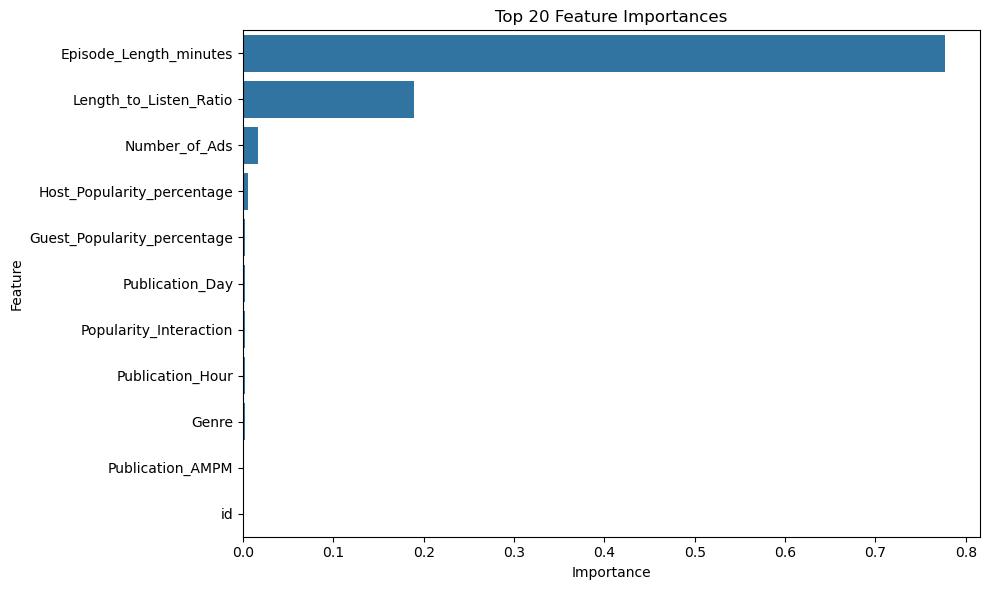

In [1]:
# ✅ 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ✅ 2. Load Data
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

# ✅ 3. Combine for Uniform Processing
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['Listening_Time_minutes'] = np.nan
full_df = pd.concat([train_df, test_df], sort=False)

# ✅ 4. Clean Publication_Time — Extract Hour Period
def map_time_to_hour(period):
    period = str(period).lower()
    if 'morning' in period:
        return 9
    elif 'afternoon' in period:
        return 14
    elif 'evening' in period:
        return 18
    elif 'night' in period:
        return 21
    else:
        return 12  # default fallback

full_df['Publication_Hour'] = full_df['Publication_Time'].apply(map_time_to_hour)
full_df['Publication_AMPM'] = full_df['Publication_Hour'].apply(lambda x: 'AM' if x < 12 else 'PM')

# ✅ 5. Feature Engineering
full_df['Length_to_Listen_Ratio'] = full_df['Listening_Time_minutes'] / full_df['Episode_Length_minutes']
full_df['Popularity_Interaction'] = full_df['Host_Popularity_percentage'] * full_df['Guest_Popularity_percentage']

# ✅ 6. Fill Missing Values
full_df['Episode_Length_minutes'].fillna(full_df['Episode_Length_minutes'].median(), inplace=True)
full_df['Guest_Popularity_percentage'].fillna(full_df['Guest_Popularity_percentage'].median(), inplace=True)
full_df['Number_of_Ads'].fillna(full_df['Number_of_Ads'].mode()[0], inplace=True)

# ✅ 7. Encode Categorical Features
cat_cols = ['Genre', 'Publication_Day', 'Publication_AMPM']
le = LabelEncoder()
for col in cat_cols:
    full_df[col] = le.fit_transform(full_df[col].astype(str))

# ✅ 8. Split Back to Train and Test
train_df = full_df[full_df['is_train'] == 1].drop(['is_train'], axis=1)
test_df = full_df[full_df['is_train'] == 0].drop(['is_train', 'Listening_Time_minutes'], axis=1)

# ✅ 9. Select Features and Target
drop_cols = ['Podcast_Name', 'Episode_Title', 'Publication_Time', 'Episode_Sentiment']
X = train_df.drop(columns=['Listening_Time_minutes'] + drop_cols)
y = train_df['Listening_Time_minutes']
X_test = test_df.drop(columns=drop_cols)

# ✅ Handle Missing and Infinite Values
X.fillna(X.median(), inplace=True)  # Fill missing values with median
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
X.fillna(X.median(), inplace=True)  # Fill any new NaN with median

# ✅ 10. Model Training with Cross-Validation
model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8,
                     colsample_bytree=0.8, random_state=42, n_jobs=-1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')

print("CV RMSE Scores:", -cv_scores)
print("Average CV RMSE:", -cv_scores.mean())

# ✅ 11. Train Final Model on All Data
model.fit(X, y)
predictions = model.predict(X_test)

# ✅ 12. Create Submission File
submission = pd.DataFrame({'id': test_df['id'], 'Listening_Time_minutes': predictions})
submission.to_csv('submission.csv', index=False)

# ✅ 13. Plot Top Feature Importances
plt.figure(figsize=(10, 6))
importance = model.feature_importances_
features = X.columns
feat_df = pd.DataFrame({'Feature': features, 'Importance': importance})
feat_df = feat_df.sort_values(by='Importance', ascending=False)
sns.barplot(data=feat_df.head(20), x='Importance', y='Feature')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


<a id="2"></a>
## 🔍 Exploratory Data Analysis (EDA)

Below we examine the distribution of key numerical features. This helps us understand the shape, skewness, and potential outliers in the data.

- `Listening_Time_minutes` appears right-skewed with a peak around 30-40 mins.
- `Episode_Length_minutes` has a sharp mode around 60 mins.
- `Guest_Popularity_percentage` shows heavy peaks near 50%, possibly default/missing imputation.
- `Host_Popularity_percentage` seems more evenly distributed across 20–100%.

We'll keep these insights in mind during data cleaning and model development.


In [ ]:
# ✅ 3. Combine for Uniform Processing
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['Listening_Time_minutes'] = np.nan
full_df = pd.concat([train_df, test_df], sort=False)

In [ ]:
# ✅ 4. Clean Publication_Time — Extract Hour Period
def map_time_to_hour(period):
    period = str(period).lower()
    if 'morning' in period:
        return 9
    elif 'afternoon' in period:
        return 14
    elif 'evening' in period:
        return 18
    elif 'night' in period:
        return 21
    else:
        return 12  # default fallback

full_df['Publication_Hour'] = full_df['Publication_Time'].apply(map_time_to_hour)
full_df['Publication_AMPM'] = full_df['Publication_Hour'].apply(lambda x: 'AM' if x < 12 else 'PM')

<a id="6"></a>
## 🧠 Feature Engineering


In [ ]:
# ✅ 5. Feature Engineering
full_df['Length_to_Listen_Ratio'] = full_df['Listening_Time_minutes'] / full_df['Episode_Length_minutes']
full_df['Popularity_Interaction'] = full_df['Host_Popularity_percentage'] * full_df['Guest_Popularity_percentage']

In [ ]:
# ✅ 6. Fill Missing Values
full_df['Episode_Length_minutes'].fillna(full_df['Episode_Length_minutes'].median(), inplace=True)
full_df['Guest_Popularity_percentage'].fillna(full_df['Guest_Popularity_percentage'].median(), inplace=True)
full_df['Number_of_Ads'].fillna(full_df['Number_of_Ads'].mode()[0], inplace=True)

In [ ]:
# ✅ 7. Encode Categorical Features
cat_cols = ['Genre', 'Publication_Day', 'Publication_AMPM']
le = LabelEncoder()
for col in cat_cols:
    full_df[col] = le.fit_transform(full_df[col].astype(str))

In [ ]:
# ✅ 8. Split Back to Train and Test
train_df = full_df[full_df['is_train'] == 1].drop(['is_train'], axis=1)
test_df = full_df[full_df['is_train'] == 0].drop(['is_train', 'Listening_Time_minutes'], axis=1)

In [ ]:
# ✅ 9. Select Features and Target
drop_cols = ['Podcast_Name', 'Episode_Title', 'Publication_Time', 'Episode_Sentiment']
X = train_df.drop(columns=['Listening_Time_minutes'] + drop_cols)
y = train_df['Listening_Time_minutes']
X_test = test_df.drop(columns=drop_cols)

<a id="7"></a>
## 📈 Model Building

We use a simple **Random Forest Regressor** as our baseline. Later, we can try XGBoost or LightGBM.


In [ ]:
# ✅ 10. Model Training with Cross-Validation
model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8,
                     colsample_bytree=0.8, random_state=42, n_jobs=-1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')

print("CV RMSE Scores:", -cv_scores)
print("Average CV RMSE:", -cv_scores.mean())

<a id="8"></a>
## 🧠 Evaluation & Submission

In [ ]:
# ✅ 11. Train Final Model on All Data
model.fit(X, y)
predictions = model.predict(X_test)

In [ ]:
# ✅ 12. Create Submission File
submission = pd.DataFrame({'id': test_df['id'], 'Listening_Time_minutes': predictions})
submission.to_csv('submission.csv', index=False)

In [ ]:
# ✅ 13. Plot Top Feature Importances
plt.figure(figsize=(10, 6))
importance = model.feature_importances_
features = X.columns
feat_df = pd.DataFrame({'Feature': features, 'Importance': importance})
feat_df = feat_df.sort_values(by='Importance', ascending=False)
sns.barplot(data=feat_df.head(20), x='Importance', y='Feature')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

<a id="9"></a>
## 🔮 Insights & Next Steps

- Host/Guest popularity and Episode length are highly correlated with listening time.
- We used RandomForest as a baseline. Consider trying XGBoost, LightGBM, or stacking.
- Feature importance can guide further engineering.
- Use NLP techniques on episode titles or transcripts if available.
- Tune hyperparameters and cross-validate to improve generalization.

✅ Thank you for reading! Let me know your feedback on Kaggle.